# Install dependencies
In order to train an object detection algorithm with yolo, you have to install darknet Just follow insstructions of the repo
https://github.com/AlexeyAB/darknet#yolo-v4-in-other-frameworks

In my case, I connected my colab to my drive and installed the darknet on my drive.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive

Mounted at /content/gdrive


In [ ]:
import os
base_dir = '/mydrive/yolo'
if not os.path.exists(base_dir):
  os.makedirs(base_dir)
%cd {base_dir}

/content/gdrive/My Drive/yolo


In [ ]:
# Images and formatted labels are save in obj
import os
data_dir = os.path.join(base_dir, 'BCCD')
obj_dir = os.path.join(data_dir, 'obj')
if not os.path.exists(obj_dir):
  os.makedirs(obj_dir)

pretrained_weight = 'yolov4-tiny.weights'
prefix = 'yolov4-bc-tiny'
config = os.path.join(data_dir, f'{prefix}.cfg')

names = os.path.join(data_dir, 'blood_cells.names')
data = os.path.join(data_dir, 'blood_cells.data')
backup = os.path.join(data_dir, 'backup')
train_file = os.path.join(data_dir, 'BC_train.txt')
test_file = os.path.join(data_dir, 'BC_test.txt')
if not os.path.exists(backup):
  os.makedirs(backup)

last_weight = os.path.join(backup, f'{prefix}_last.weights')
best_weight = os.path.join(backup, f'{prefix}_best.weights')

In [ ]:
# Then, if darknet is not installed: 
if not os.path.exists('darknet'):
  !git clone https://github.com/AlexeyAB/darknet
  !cd darknet/
  !sed -i 's/OPENCV=0/OPENCV=1/' Makefile
  !sed -i 's/GPU=0/GPU=1/' Makefile
  !sed -i 's/CUDNN=0/CUDNN=1/' Makefile
  !sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
  !sed -i 's/LIBSO=0/LIBSO=1/' Makefile
  !make
else:
  !cd darknet/
# Makesure darknet has execution permission
!chmod 777 darknet

# Prepare training data
First, download the public blood cell dataset from github [BCCD_Dataset](https://github.com/Shenggan/BCCD_Dataset).
This dataset contains 364 images and 364 annotation files in Pascal VOC format (xml).
The JPEGImages: are 480x640 (height * width)
There are 3 classes: RBC (Red Blood Cell), WBC (White Blood Cell) and Platelets (血小板)


Data is expected to structured as

darknet/data/
  - obj/, with images and labels
  - blood_cells.names: contains label name. One label per row
  - blood_cells.cfg: yolo configuration
  - blood_cells.data: with the following information
    - classes = 4
    - train  = txt file with train image path
    - valid  = txt file with validation image path
    - names = file with labels
    - backup = where to save the training files

In [ ]:
!git clone https://github.com/Shenggan/BCCD_Dataset.git

In [ ]:
import glob
images = glob.glob('BCCD_Dataset/BCCD/JPEGImages/*.jpg')
annotations = glob.glob('BCCD_Dataset/BCCD/Annotations/*.xml')
# YOLO labels starts from 0
label_map = {"RBC": 0, "WBC": 1, "Platelets": 2}
print(f"The dataset has {len(images)} images and {len(annotations)} annotation files")

The dataset has 0 images and 0 annotation files


In [ ]:
# Then, we are going to export xml to YOLO format
import os, sys, random
import xml.etree.ElementTree as ET
def normalize(cx, cy, w, h, image_width, image_height):
  cx = cx/image_width
  cy = cy/image_height
  w = w/image_width
  h = h/image_height
  return  cx, cy, w, h


def voc2yolo(annotations, label_map, outdir):
  """
  YOLO expects a txt file for each image, each row contains
  <object-class> <x_center> <y_center> <width> <height>
  where object-class is int
  """

  df = []
  cnt = 0
  for file in annotations:

      filename = os.path.basename(file).replace('.xml', '.txt')
      outname = os.path.join(outdir, filename)

      row = []
      
      parsedXML = ET.parse(file)
      root = parsedXML.getroot()
      for node in root.iter('size'):
        image_width = int(node.find('width').text)
        image_height = int(node.find('height').text)
      with open(outname, 'w') as f:
        for node in root.iter('object'):
            label_str = node.find('name').text
            xmin = int(node.find('bndbox/xmin').text)
            xmax = int(node.find('bndbox/xmax').text)
            ymin = int(node.find('bndbox/ymin').text)
            ymax = int(node.find('bndbox/ymax').text)

            cx = (xmax+xmin)//2
            cy = (ymax+ymin)//2
            w = xmax-xmin
            h = ymax-ymin
            cx, cy, w, h = normalize(cx, cy, w, h, image_width, image_height)
            label_int = label_map[label_str]
            out_info = f"{label_int} {cx} {cy} {w} {h}\n"
            f.write(out_info)

In [ ]:
voc2yolo(annotations[:1], label_map, obj_dir)

In [ ]:
import shutil
for image in images:
  shutil.copy(image, obj_dir)

In [ ]:
# Then, check that the data we have prepared is correct by plotting
import numpy as np
import cv2
import matplotlib.pyplot as plt
def check_bboxes(obj_dir, filename, colors=None):
    # <object-class> <x_center> <y_center> <width> <height>
    
    with open(os.path.join(obj_dir, f'{filename}.txt')) as f:
      bboxes = f.readlines()
      bboxes = [box.strip('\n').split(" ") for box in bboxes]
    bboxes = np.array(bboxes, dtype=float)

    image = cv2.imread(os.path.join(obj_dir, f'{filename}.jpg'))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    height,width = image.shape[:2]
    cx = bboxes[:,1]*width
    cy = bboxes[:,2]*height
    w = bboxes[:,3]*width
    h = bboxes[:,4]*height
    xmin = cx-w//2
    xmax = cx+w//2
    ymin = cy-h//2
    ymax = cy+h//2
    bboxes_mod = np.zeros_like(bboxes, dtype=int)
    bboxes_mod[:,4] = bboxes[:,0]
    bboxes_mod[:,0] = ymin
    bboxes_mod[:,1] = xmin
    bboxes_mod[:,2] = ymax
    bboxes_mod[:,3] = xmax
    
    for ymin, xmin, ymax, xmax, label in bboxes_mod:
        color = colors[label] if colors is not None else (255,0,0)
        cv2.rectangle(image, pt1=(xmin, ymin), pt2=(xmax, ymax), color=color,thickness=2)
    plt.imshow(image)
    plt.show()

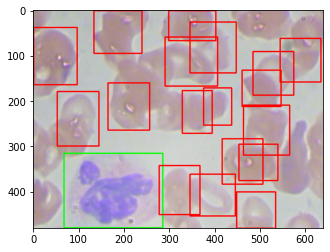

In [ ]:
# Make sure your color list is larger than the number of classes
colors = [(255,0,0), (0,255,0), (0,0,255)]
filename = 'BloodImage_00001'
check_bboxes(obj_dir, filename, colors)

In [ ]:
# Now we can remove the original folder
!rm -rf BCCD_Dataset

In [ ]:
# Split into 2 dataset and generate txt
import random

def save_txt(messages, outname):
  with open(outname, 'w') as f:
    for message in messages:
      out_info = f"{message}\n"
      f.write(out_info)
train_size = 0.8
test_size = 0.2


images = glob.glob(os.path.join(obj_dir, '*.jpg'))
random.shuffle(images)
N_train = int(len(images)*train_size)

train = images[:N_train]
test = images[N_train:]
save_txt(train, train_file)
save_txt(test, test_file)

In [ ]:
!head {test_file}

/mydrive/yolo/BCCD/obj/BloodImage_00240.jpg
/mydrive/yolo/BCCD/obj/BloodImage_00111.jpg
/mydrive/yolo/BCCD/obj/BloodImage_00114.jpg
/mydrive/yolo/BCCD/obj/BloodImage_00382.jpg
/mydrive/yolo/BCCD/obj/BloodImage_00245.jpg
/mydrive/yolo/BCCD/obj/BloodImage_00174.jpg
/mydrive/yolo/BCCD/obj/BloodImage_00236.jpg
/mydrive/yolo/BCCD/obj/BloodImage_00197.jpg
/mydrive/yolo/BCCD/obj/BloodImage_00233.jpg
/mydrive/yolo/BCCD/obj/BloodImage_00340.jpg


In [ ]:
save_txt(label_map.keys(), names)
!head {names}

RBC
WBC
Platelets


In [ ]:
# Finally, create blood_cells.data
import sys

messages = [
            "classes = 3",
            f"train = {train_file}",
            f"valid = {test_file}",
            f"names = {names}",
            f"backup = {backup}"
]
save_txt(messages, data)
!cat {data}

classes = 3
train = /mydrive/yolo/BCCD/BC_train.txt
valid = /mydrive/yolo/BCCD/BC_test.txt
names = /mydrive/yolo/BCCD/blood_cells.names
backup = /mydrive/yolo/BCCD/backup


In [ ]:
# Download pretrained weights
if pretrained_weight=='yolov4-tiny.weights':
  !wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.weights
  !wget https://github.com/AlexeyAB/darknet/blob/master/cfg/yolov4-tiny-custom.cfg
else:
  # !wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights
  !wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137
  !wget https://github.com/AlexeyAB/darknet/blob/master/cfg/yolov4.cfg

In [ ]:
!cp {os.path.join(base_dir, 'darknet', 'cfg', 'yolov4-tiny-custom.cfg')} {config}

Then configure:
- change line batch to batch=64
- change line subdivisions to subdivisions=16
- change line max_batches to (classes*2000, but not less than number of training images and not less than 6000), f.e. max_batches=6000 if you train for 3 classes
- change line steps to 80% and 90% of max_batches, f.e. steps=4800,5400
- set network size width=640 height=480
- change line classes=3 in each of 3 [yolo]-layers:
- change [filters=255] to filters=(classes + 5)x3 in the 3 [convolutional] before each [yolo] layer, keep in mind that it only has to be the last [convolutional] before each of the [yolo] layers. In our case, 3 classes, so filters=(3+5)*3=24

In [ ]:
!cat {config}

[net]
# Testing
#batch=1
#subdivisions=1
# Training
batch=64
subdivisions=16
width=640
height=480
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.00261
burn_in=1000
max_batches = 6000
policy=steps
steps=4800,5400
scales=.1,.1

[convolutional]
batch_normalize=1
filters=32
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[route]
layers=-1
groups=2
group_id=1

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=leaky

[route]
layers = -1,-2

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=leaky

[route]
layers = -6,-1

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[route]
la

In [ ]:

# define helper functions

import cv2
from google.colab import files
import matplotlib.pyplot as plt
%matplotlib inline

def imShow(path):
  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

# use this to upload files
def upload():
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)

# use this to download a file  
def download(path):
  files.download(path)

# Train

At the first time, use pretrained weights, if you have already trained some iteration and want to continiue the training, use `*_last.weights`. 
Note that 

In [ ]:
%cd {os.path.join(base_dir, 'darknet')}
!chmod +x darknet

/content/gdrive/My Drive/yolo/darknet


In [ ]:
logfile = os.path.join(data_dir, 'training_log.txt')
if not os.path.exists(last_weight):
  !./darknet detector train {data} {config} {pretrained_weight} -dont_show -map
else:
  !./darknet detector train {data} {config} {last_weight} -dont_show -map

In [ ]:
# Evaluate 
!./darknet detector map {data} {config} {best_weight} -dont_show -map

# Test
Some flags:


*   `-thresh`
*   `-ext_output`: You can output bounding box coordinates for each detection with the flag '-ext_output'. This external outputs flag will give you a few extra details about each detection within an image.
* `-dont_show`: You can add the flag '-dont_show' to not have the image outputted after running darknet. This doesn't really affect anything when running in Colab as the image is unable to output properly straight from darknet anyways. However, by adding the -dont_show flag you will get rid of the following warning from showing.
* `-out`: save result into a json.


In [ ]:
!head {test_file}

/mydrive/yolo/BCCD/obj/BloodImage_00240.jpg
/mydrive/yolo/BCCD/obj/BloodImage_00111.jpg
/mydrive/yolo/BCCD/obj/BloodImage_00114.jpg
/mydrive/yolo/BCCD/obj/BloodImage_00382.jpg
/mydrive/yolo/BCCD/obj/BloodImage_00245.jpg
/mydrive/yolo/BCCD/obj/BloodImage_00174.jpg
/mydrive/yolo/BCCD/obj/BloodImage_00236.jpg
/mydrive/yolo/BCCD/obj/BloodImage_00197.jpg
/mydrive/yolo/BCCD/obj/BloodImage_00233.jpg
/mydrive/yolo/BCCD/obj/BloodImage_00340.jpg


In [ ]:
threshold = 0.3
img_name = '/mydrive/yolo/BCCD/obj/BloodImage_00240.jpg'

In [ ]:
!./darknet detector test {data} {config} {best_weight} {img_name} -dont_show --thresh 0.5

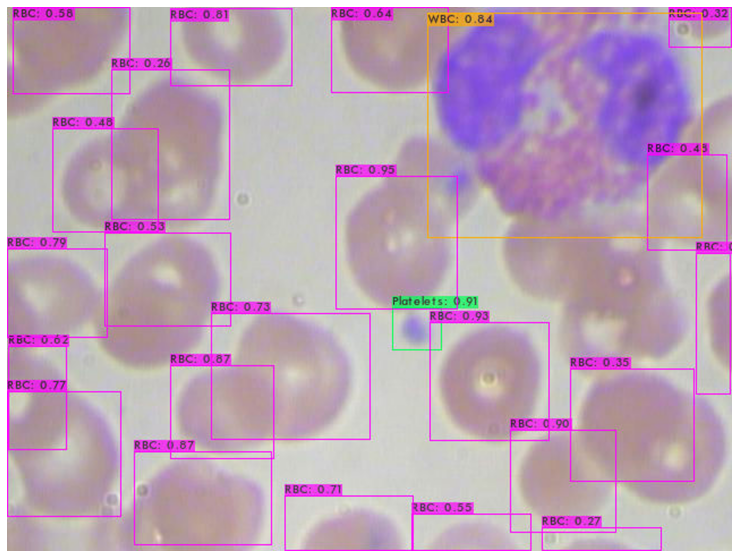

In [ ]:
imShow('predictions.jpg')

In order to test multiple images at once, create an .txt, one path to an image per line, and save result to .json


In [ ]:
!./darknet detector test \
  {data} \
  {config} \
  {best_weight} \
  -ext_output -dont_show -out result.json < {test_file}

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 2    640 x 480 x   3 ->  320 x 240 x  32 0.133 BF
   1 conv     64       3 x 3/ 2    320 x 240 x  32 ->  160 x 120 x  64 0.708 BF
   2 conv     64       3 x 3/ 1    160 x 120 x  64 ->  160 x 120 x  64 1.416 BF
   3 route  2 		                       1/2 ->  160 x 120 x  32 
   4 conv     32       3 x 3/ 1    160 x 120 x  32 ->  160 x 120 x  32 0.354 BF
   5 conv     32       3 x 3/ 1    160 x 120 x  32 ->  160 x 120 x  32 0.354 BF
   6 route  5 4 	                           ->  160 x 120 x  64 
   7 conv     64       1 x 1/ 1    160 x 120 x  64 ->  160 x 120 x  64 0.157 BF
   8 route  2 7 	    

In [ ]:
!head result.json

[
{
 "frame_id":1, 
 "filename":"/mydrive/yolo/BCCD/obj/BloodImage_00240.jpg", 
 "objects": [ 
  {"class_id":2, "name":"Platelets", "relative_coordinates":{"center_x":0.564995, "center_y":0.591629, "width":0.066889, "height":0.075921}, "confidence":0.912349}, 
  {"class_id":1, "name":"WBC", "relative_coordinates":{"center_x":0.769760, "center_y":0.218641, "width":0.378526, "height":0.412704}, "confidence":0.836027}, 
  {"class_id":0, "name":"RBC", "relative_coordinates":{"center_x":0.537986, "center_y":0.433057, "width":0.167575, "height":0.243952}, "confidence":0.952333}, 
  {"class_id":0, "name":"RBC", "relative_coordinates":{"center_x":0.665286, "center_y":0.688774, "width":0.164807, "height":0.218232}, "confidence":0.930457}, 
  {"class_id":0, "name":"RBC", "relative_coordinates":{"center_x":0.767036, "center_y":0.871876, "width":0.146120, "height":0.186830}, "confidence":0.896514}, 


# Convert to tersorflow

For more information, see https://github.com/hunglc007/tensorflow-yolov4-tflite



Before the convertion, 
* Install tensorflow==2.3.0, otherwise will report error: "error: is not immutable, try removing mutable variables in your model since mutable variables are currently not supported through this converter"
* upload your object names (filarias.names) to /content/tensorflow-yolov4-tflite/data/classes. See [issue](https://github.com/hunglc007/tensorflow-yolov4-tflite/issues/147)
* modify line 14: /content/tensorflow-yolov4-tflite/core/config.py: `__C.YOLO.CLASSES              = "./data/classes/blood_cells.names"`
* I had the same issue with the latest yolov4-tiny.cfg . After changing the anchors and xyscale in core/config.py to match the ones from the cfg-file, the bounding boxes seem to be correct again.

In [ ]:
!pip install tensorflow==2.3.0

In [ ]:
import tensorflow as tf
tf.__version__

'2.3.0'

In [ ]:
%cd /content

/content


In [ ]:
!git clone https://github.com/hunglc007/tensorflow-yolov4-tflite.git

Cloning into 'tensorflow-yolov4-tflite'...
remote: Enumerating objects: 790, done.
remote: Total 790 (delta 0), reused 0 (delta 0), pack-reused 790
Receiving objects: 100% (790/790), 197.64 MiB | 16.95 MiB/s, done.
Resolving deltas: 100% (375/375), done.


In [ ]:
%cd tensorflow-yolov4-tflite/

/content/tensorflow-yolov4-tflite


In [ ]:
# Copy blood_cells.names to the corresponding folder, then modify /content/tensorflow-yolov4-tflite/core/config.py
!cp {names} /content/tensorflow-yolov4-tflite/data/classes

In [ ]:
size = 640
tf_model = os.path.join(data_dir, 'backup', f'{prefix}-tf')
ckpt = os.path.join(data_dir, 'backup', f'{prefix}-ckpt')
weights = os.path.join(data_dir, 'backup', f'{prefix}_best.weights')
inference_type = "UINT8"
quantized_file = os.path.join(ckpt, f'{prefix}_{inference_type}.tflite')

img_name = '/mydrive/yolo/BCCD/obj/BloodImage_00240.jpg'

In [ ]:
!python save_model.py \
  --weights {best_weight} \
  --output {tf_model} \
  --input_size {size} \
  --model yolov4 --tiny

In [ ]:
# check the exported model is correct
output = 'prediction_tf.jpg'
!python detect.py \
  --weights {tf_model} \
  --size 640 \
  --image {img_name} \
  --output {output} \
  --iou 0.5 \
  --score 0.2 \
  --model yolov4 \
  --tiny \
  --framework tf

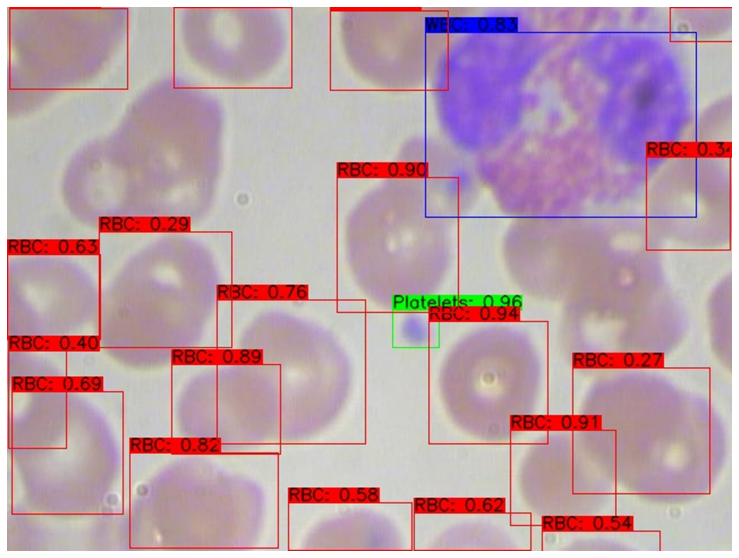

In [ ]:
imShow(output)

In [ ]:
# Save tf model for tflite converting
!python save_model.py \
  --weights {best_weight} \
  --output {ckpt} \
  --input_size 640 \
  --model yolov4 \
  --tiny \
  --framework tflite

In [ ]:
ckpt

'/mydrive/yolo/BCCD/backup/yolov4-bc-tiny-ckpt'

In [ ]:
# yolov4
!python convert_tflite.py \
  --weights {ckpt} \
  --output {tflite_model_quant} \
  --input_size 640

In [ ]:
img_name

'/mydrive/yolo/BCCD/obj/BloodImage_00240.jpg'

In [ ]:
!python detect.py \
  --weights {tflite_model_quant} \
  --size 640 \
  --image  /mydrive/yolo/BCCD/obj/BloodImage_00240.jpg \
  --iou 0.5 \
  --score 0.2 \
  --output 'prediction_tflite.png' \
  --framework tflite \
  --model yolov4 \
  --tiny

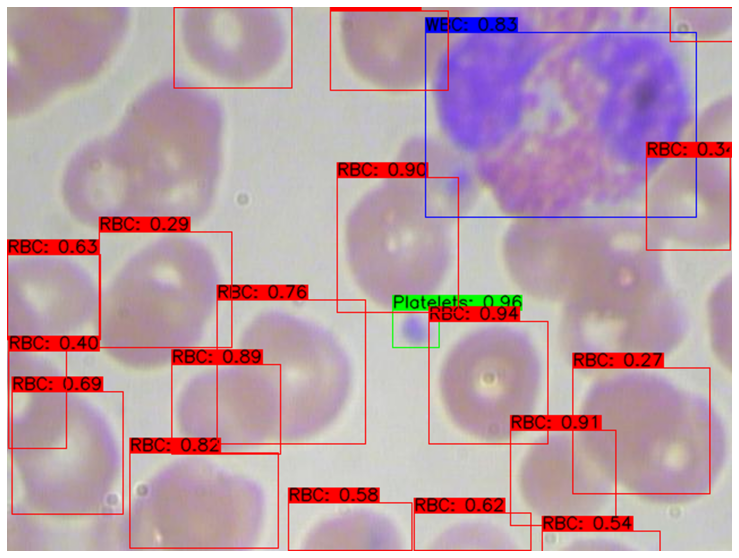

In [ ]:
imShow('prediction_tflite.png')

In [ ]:
import tensorflow as tf
import numpy as np
import os
def quantization(saved_model, inference_type, quantized_file):
  converter = tf.lite.TFLiteConverter.from_saved_model(saved_model)
  converter.allow_custom_ops=False
  if inference_type == 'UINT8':
      #The simplest form of post-training quantization statically quantizes only the weights from 
      #floating point to integer, which has 8-bits of precision:
      # quantize and export the tflite graph
      print('Quantizing Lite graph for dynamic inference type...')
      converter.optimizations = [tf.lite.Optimize.DEFAULT]
  elif inference_type == 'FLOAT16':
      print('Quantizing Lite graph for FLOAT inference type...')
      converter.optimizations = [tf.lite.Optimize.DEFAULT]
      converter.target_spec.supported_types = [tf.float16]

  tflite_quant_model = converter.convert()
  with open(quantized_file, "wb") as tflite_file:
      tflite_file.write(tflite_quant_model)

quantization(ckpt, inference_type, quantized_file)

Quantizing Lite graph for dynamic inference type...
